# Data Pre-processing

Lets read the data we gatherd and convert it to a dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from yelphelpers import *

warnings.filterwarnings('ignore')

with open('dallas_restaurants.json') as f:
    data = json.load(f)
    
with open('categories.json') as f:
    cats = json.load(f)

In [2]:
df = pd.DataFrame.from_dict(data, orient='columns')
df.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,UAWZeXCm9wkiJyzJxhuSZg,kebabs-to-go-irving-10,Kebabs To Go!,https://s3-media1.fl.yelpcdn.com/bphoto/cKrhCh...,False,https://www.yelp.com/biz/kebabs-to-go-irving-1...,116,"[{'alias': 'mediterranean', 'title': 'Mediterr...",4.5,"{'latitude': 32.85655, 'longitude': -96.99186}","[pickup, delivery]",$,"{'address1': '3662 N Belt Line Rd', 'address2'...",+12144419881,(214) 441-9881,17953.489770
1,yWGG4oa9WdIECDD4O6P8-Q,nora-restaurant-and-bar-dallas,Nora Restaurant and Bar,https://s3-media4.fl.yelpcdn.com/bphoto/oje7HH...,False,https://www.yelp.com/biz/nora-restaurant-and-b...,325,"[{'alias': 'afghani', 'title': 'Afghan'}, {'al...",4.0,"{'latitude': 32.7465181, 'longitude': -96.8284...","[pickup, delivery]",$$,"{'address1': '205 N Bishop Ave', 'address2': '...",+12148280095,(214) 828-0095,10601.439932
2,vVbHqc5kyAJv6Bw_-Rnq6g,kebabs-to-go-irving-3,Kebabs To Go,https://s3-media1.fl.yelpcdn.com/bphoto/p3zZjh...,False,https://www.yelp.com/biz/kebabs-to-go-irving-3...,570,"[{'alias': 'afghani', 'title': 'Afghan'}, {'al...",4.5,"{'latitude': 32.9420797869367, 'longitude': -9...","[pickup, delivery]",$$,"{'address1': '10025 N MacArthur Blvd', 'addres...",+19729100127,(972) 910-0127,18259.106765
3,nwDptayZCNOcwWpGVB5hBQ,express-kabob-plano,Express Kabob,https://s3-media1.fl.yelpcdn.com/bphoto/Lug5yv...,False,https://www.yelp.com/biz/express-kabob-plano?a...,146,"[{'alias': 'afghani', 'title': 'Afghan'}, {'al...",4.0,"{'latitude': 33.0277483460284, 'longitude': -9...","[pickup, delivery]",$$,"{'address1': '1915 Central Expwy', 'address2':...",+14692980189,(469) 298-0189,22559.477801
4,CinPf_89qNgKRH-Dogl--w,shuri-dallas-2,Shuri,https://s3-media3.fl.yelpcdn.com/bphoto/uN4E-m...,False,https://www.yelp.com/biz/shuri-dallas-2?adjust...,23,"[{'alias': 'african', 'title': 'African'}]",3.0,"{'latitude': 32.9233488531959, 'longitude': -9...",[delivery],$$,"{'address1': '9410 Walnut St', 'address2': 'St...",+19728638820,(972) 863-8820,11128.973084


In [3]:
print("Missing data:")
df.isnull().sum()

Missing data:


id                 0
alias              0
name               0
image_url          0
is_closed          0
url                0
review_count       0
categories         0
rating             0
coordinates        0
transactions       0
price            726
location           0
phone              0
display_phone      0
distance           0
dtype: int64

# Cleaning the data

Here, we need to:
- Remove unnecessary data
- One-hot encode categories list
- Convert string data into numeric data (rating, price)
- Add neighbourhood name based on zip code

In [4]:
#  Remove unnecessary data
df = df.drop(columns=['image_url','is_closed','transactions','phone','display_phone'])

# Replace restruarant price tags ($) with numerical values
df.replace(['$','$$','$$$','$$$$'],[1.0,2.0,3.0,4.0], inplace=True)


# Expand the list, "categories", into separate columns (one-hot encoding)
df_categories = df[['id', 'categories']]
df.drop(columns=['categories'],inplace=True)
df.rename(columns={'alias':'r_alias'},inplace=True)

df_expanded = df.merge(expand_list(df_categories, 'categories'))
df_categories = expand_list(df_categories,'categories')
df_categories = pd.concat([df_categories.drop(['categories'], axis=1), df_categories['categories'].apply(pd.Series)], axis=1)
df_categories = df_categories.groupby(['id']).agg(lambda x: tuple(x)).applymap(list).reset_index()

df = df.merge(df_categories, on='id')
df = df.drop('alias', 1).join(df.alias.str.join('|').str.get_dummies())


# To find categorical data, we need to split restaurants with multiple categories into separate entries.
df_expanded = pd.concat([df_expanded.drop(['categories'], axis=1), df_expanded['categories'].apply(pd.Series)], axis=1)

# Clean up some variables to leave more space
df_categories = None

In [5]:
df.head()

,id,r_alias,name,url,review_count,rating,coordinates,price,location,distance,...,vegan,vegetarian,venezuelan,venues,vietnamese,waffles,whiskeybars,wine_bars,winetastingroom,wraps
0,UAWZeXCm9wkiJyzJxhuSZg,kebabs-to-go-irving-10,Kebabs To Go!,https://www.yelp.com/biz/kebabs-to-go-irving-1...,116,4.5,"{'latitude': 32.85655, 'longitude': -96.99186}",1.0,"{'address1': '3662 N Belt Line Rd', 'address2'...",17953.489770,...,0,0,0,0,0,0,0,0,0,0
1,UAWZeXCm9wkiJyzJxhuSZg,kebabs-to-go-irving-10,Kebabs To Go!,https://www.yelp.com/biz/kebabs-to-go-irving-1...,116,4.5,"{'latitude': 32.85655, 'longitude': -96.99186}",1.0,"{'address1': '3662 N Belt Line Rd', 'address2'...",17953.489770,...,0,0,0,0,0,0,0,0,0,0
2,yWGG4oa9WdIECDD4O6P8-Q,nora-restaurant-and-bar-dallas,Nora Restaurant and Bar,https://www.yelp.com/biz/nora-restaurant-and-b...,325,4.0,"{'latitude': 32.7465181, 'longitude': -96.8284...",2.0,"{'address1': '205 N Bishop Ave', 'address2': '...",10601.439932,...,0,0,0,0,0,0,0,0,0,0
3,vVbHqc5kyAJv6Bw_-Rnq6g,kebabs-to-go-irving-3,Kebabs To Go,https://www.yelp.com/biz/kebabs-to-go-irving-3...,570,4.5,"{'latitude': 32.9420797869367, 'longitude': -9...",2.0,"{'address1': '10025 N MacArthur Blvd', 'addres...",18259.106765,...,0,0,0,0,0,0,0,0,0,0
4,nwDptayZCNOcwWpGVB5hBQ,express-kabob-plano,Express Kabob,https://www.yelp.com/biz/express-kabob-plano?a...,146,4.0,"{'latitude': 33.0277483460284, 'longitude': -9...",2.0,"{'address1': '1915 Central Expwy', 'address2':...",22559.477801,...,0,0,0,0,0,0,0,0,0,0


# Summary Statistics

### Overall assessment of review_count, rating and price
Here, we take a look at the general statistics for restuarant data

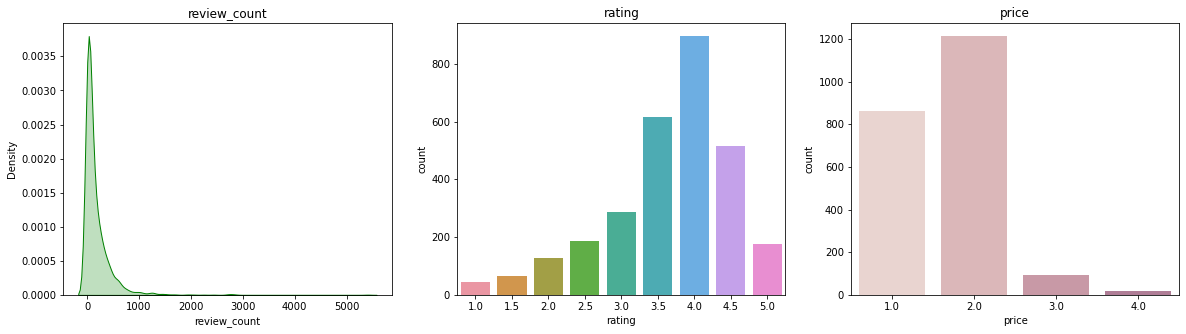

In [6]:
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.set_palette(sns.cubehelix_palette(8))
sns.distplot(df['review_count'], hist=False, color="g", ax=axes[0], kde_kws={"shade": True}).set_title('review_count')
sns.countplot(df['rating'],ax=axes[1]).set_title('rating')
sns.countplot(df['price'],ax=axes[2]).set_title('price')
plt.show()

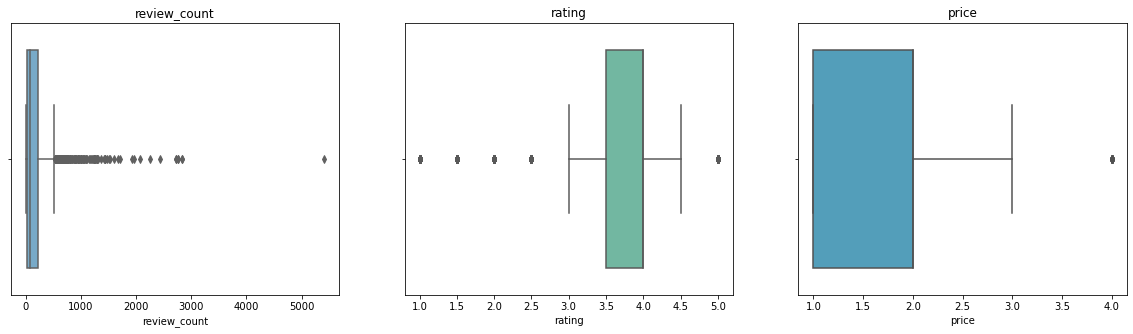

In [7]:
# Boxplots to identify outliers
fig, axes = plt.subplots(1,3,figsize=(20,5))
sns.boxplot(df['review_count'],ax=axes[0],palette='Blues').set_title('review_count')
sns.boxplot(df['rating'],ax=axes[1], palette='BuGn_r').set_title('rating')
sns.boxplot(df['price'],ax=axes[2], palette='GnBu_d').set_title('price')
plt.show()

### Categorical assessment of review_count, rating, price and total number of restuarants
Here we find the above statistics by category. The Bayesian averge of each property was used to graph it by category in descending order.

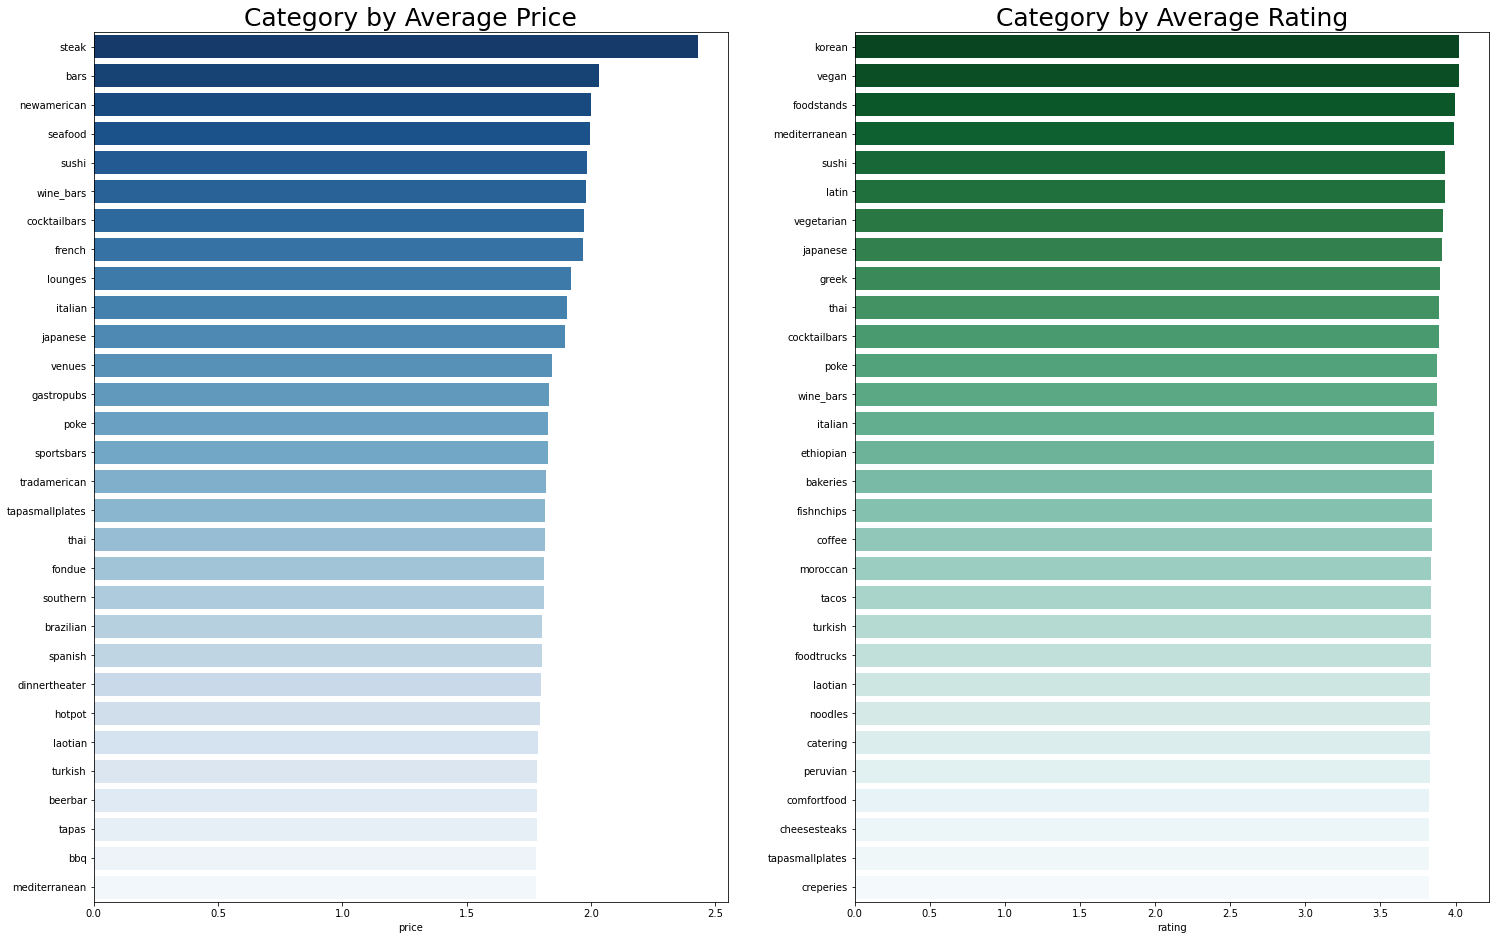

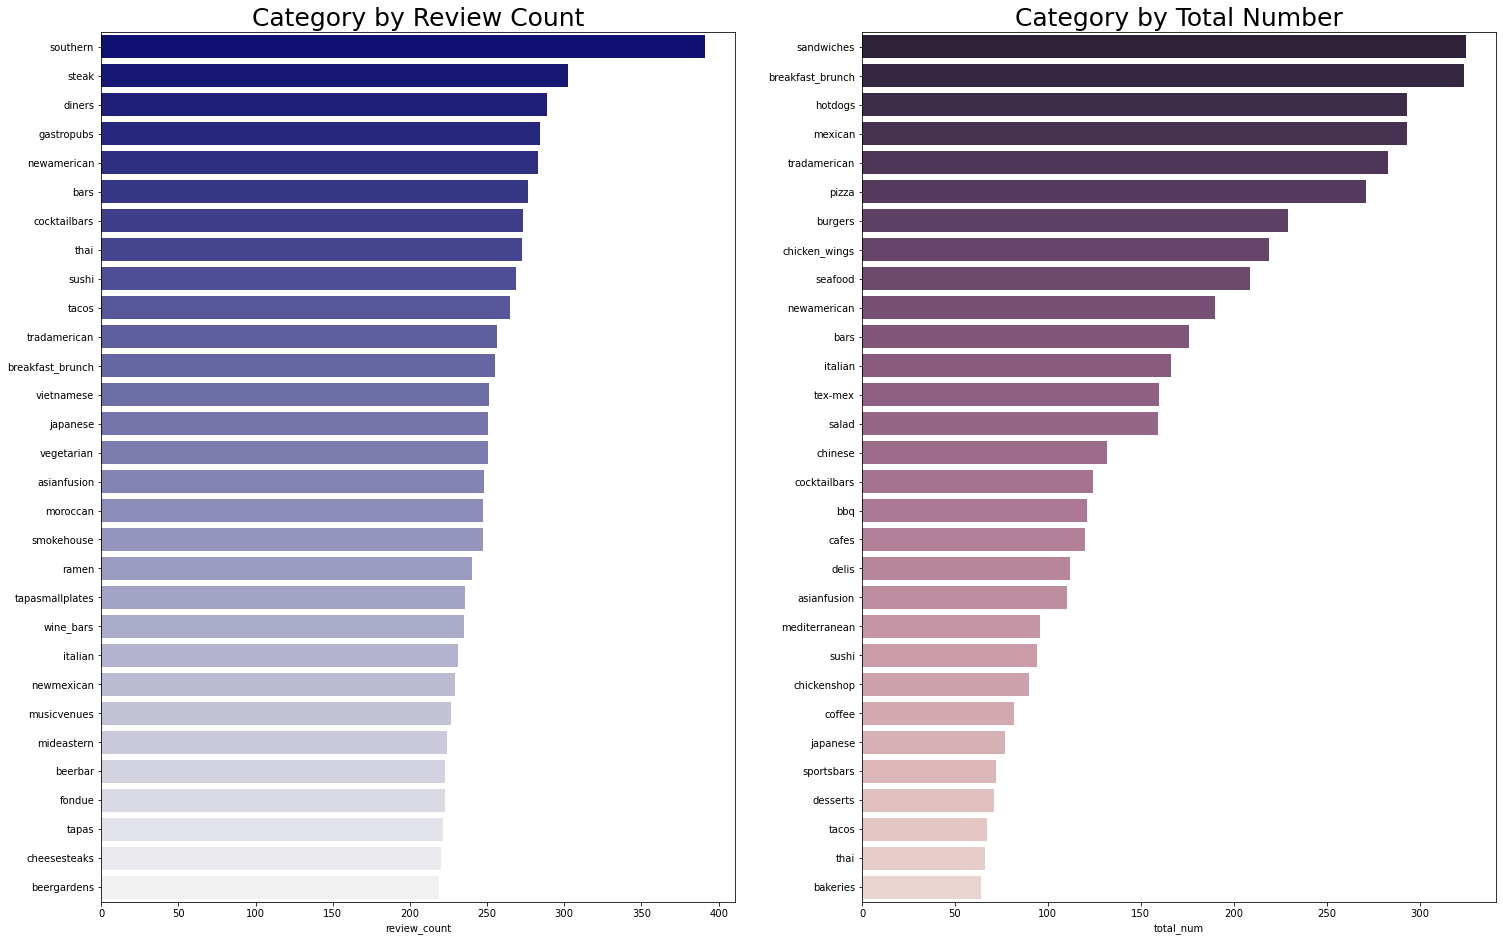

In [8]:
n = 30

### PRICE ###
pr = (bayes_avg(df_expanded.dropna(how='any'), 'alias', 'price').sort_values(ascending=False)
     .reset_index().sort_values('price', ascending=False))
pr = pr.iloc[:n]
### RATING
ra = (bayes_avg(df_expanded, 'alias', 'rating').sort_values(ascending=False)
     .reset_index().sort_values('rating', ascending=False))
ra = ra.iloc[:n]
### REVIEW_COUNT
re = (bayes_avg(df_expanded, 'alias', 'review_count').sort_values(ascending=False)
     .reset_index().sort_values('review_count', ascending=False))
re = re.iloc[:n]
### NUMBER OF RESTAURANTS
nu = (df.drop(['id', 'r_alias', 'name','url','review_count','rating','coordinates','price','location', \
         'distance', 'title'], axis=1).sum().sort_values(ascending=False))
nu = nu.reset_index().iloc[:n]
nu.rename(columns={'index': 'alias', 0:'total_num'}, inplace=True)




# first fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette(sns.cubehelix_palette(8))
sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(25,16))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=n, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(n, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()

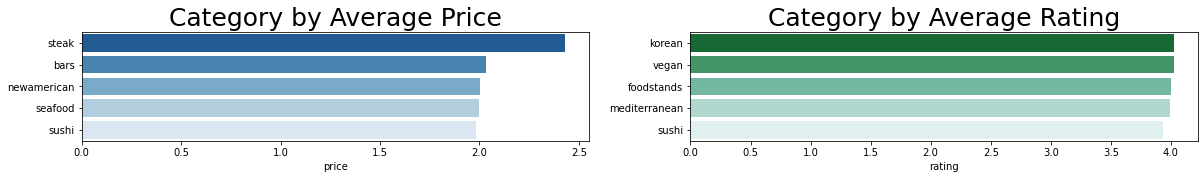

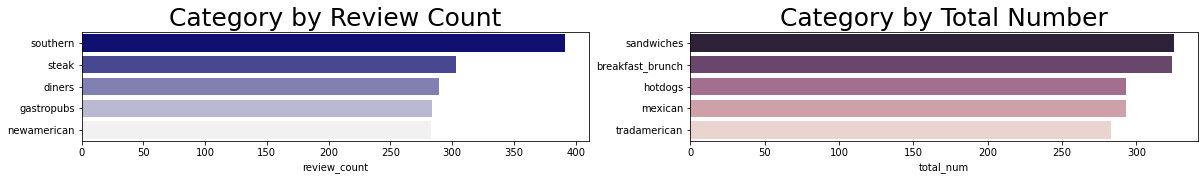

In [9]:
# let's map the top 5 of each category
m = 5

pr,ra,re,nu = pr.iloc[:m], ra.iloc[:m], re.iloc[:m], nu.iloc[:m]

#first fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette(sns.cubehelix_palette(8))

sns.barplot(data=pr,x='price',y='alias',orient='h',ax=axes[0], palette="Blues_r").set_title('Category by Average Price', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=ra,x='rating',y='alias',orient='h',ax=axes[1], palette="BuGn_r").set_title('Category by Average Rating', fontsize=25)
axes[1].set_ylabel('')

# second fig
fig, axes = plt.subplots(1,2,figsize=(20,2))
sns.set_palette('ch:8')

sns.barplot(data=re,x='review_count',y='alias',orient='h',ax=axes[0], palette=sns.light_palette("navy", n_colors=m, reverse=True)).set_title('Category by Review Count', fontsize=25)
axes[0].set_ylabel('')

sns.barplot(data=nu,x='total_num',y='alias',orient='h',ax=axes[1], palette=sns.cubehelix_palette(m, reverse=True)).set_title('Category by Total Number', fontsize=25)
axes[1].set_ylabel('')

plt.show()


# Geographic Data
geojson file that has Dallas sip code boundary coordinates can be found [here](https://github.com/codeforgermany/click_that_hood/blob/main/public/data/vancouver.geojson).

This [site](https://www.geonames.org/postal-codes/CA/BC/british-columbia.html) contains the zip codes and the area names in Dallas. So I matched the names from geojson file to the coresponding area names.

In [10]:
# Run this in cmd opend as Administrator to install folium package
# conda install -c conda-forge/label/gcc7 folium

In [52]:
import folium

with open('dallas.geojson',) as f:
    geojson = json.load(f)


# edit current dataframe to be readable by folium
df['zip_code'] = pd.concat([df.drop(['location'], axis=1), df['location'].apply(pd.Series)], axis=1)['zip_code']

In [24]:
df['location'].apply(pd.Series).head()

,address1,address2,address3,city,zip_code,country,state,display_address
0,3662 N Belt Line Rd,None,,Irving,75062,US,TX,"[3662 N Belt Line Rd, Irving, TX 75062]"
1,3662 N Belt Line Rd,None,,Irving,75062,US,TX,"[3662 N Belt Line Rd, Irving, TX 75062]"
2,205 N Bishop Ave,,,Dallas,75208,US,TX,"[205 N Bishop Ave, Dallas, TX 75208]"
3,10025 N MacArthur Blvd,,,Irving,75063,US,TX,"[10025 N MacArthur Blvd, Irving, TX 75063]"
4,1915 Central Expwy,Ste 200,,Plano,75075,US,TX,"[1915 Central Expwy, Ste 200, Plano, TX 75075]"


### Applying zip code to location

In [25]:
df['length'] = df['zip_code'].apply(lambda x: len(x))
df['length'].value_counts()

5    2914
0       2
Name: length, dtype: int64

In [26]:
df[df.length==0]['zip_code']

872     
2325    
Name: zip_code, dtype: object

Looks like the zip data comes in different lengths.
- zip codes that have a length of 3 and 7 are in postal code format. 
- Zip codes with length 5 are in the form of American zip codes. 
- Because there are only 25 missing zip codes, we will ignore those.

In [27]:
df['location'].apply(pd.Series)[['city','zip_code']]

,city,zip_code
0,Irving,75062
1,Irving,75062
2,Dallas,75208
3,Irving,75063
4,Plano,75075
...,...,...
2911,Dallas,75230
2912,Dallas,75230
2913,Dallas,75243
2914,Dallas,75225


In [28]:
df['zip_code']

0       75062
1       75062
2       75208
3       75063
4       75075
        ...  
2911    75230
2912    75230
2913    75243
2914    75225
2915    75202
Name: zip_code, Length: 2916, dtype: object

In [153]:
zipcodes_file = open("dallas_zipcodes.txt", "r")

zipcode_dic = {}
for line in zipcodes_file.readlines():
    zipcode_line = line.split('\t')
    zipcode_dic.update({zipcode_line[0]: zipcode_line[1]})
    
zipcode_dic

{'75001': 'Addison',
 '75006': 'Carrollton',
 '75011': 'Carrollton',
 '75014': 'Irving',
 '75015': 'Irving',
 '75016': 'Irving',
 '75017': 'Irving',
 '75019': 'Coppell',
 '75030': 'Rowlett',
 '75038': 'Irving',
 '75039': 'Irving',
 '75040': 'Garland',
 '75041': 'Garland',
 '75042': 'Garland',
 '75043': 'Garland',
 '75044': 'Garland',
 '75045': 'Garland',
 '75046': 'Garland',
 '75047': 'Garland',
 '75048': 'Sachse',
 '75049': 'Garland',
 '75050': 'Grand Prairie',
 '75051': 'Grand Prairie',
 '75052': 'Grand Prairie',
 '75053': 'Grand Prairie',
 '75054': 'Grand Prairie',
 '75060': 'Irving',
 '75061': 'Irving',
 '75062': 'Irving',
 '75063': 'Irving',
 '75080': 'Richardson',
 '75081': 'Richardson',
 '75082': 'Richardson',
 '75083': 'Richardson',
 '75085': 'Richardson',
 '75088': 'Rowlett',
 '75089': 'Rowlett',
 '75104': 'Cedar Hill',
 '75106': 'Cedar Hill',
 '75115': 'DeSoto',
 '75116': 'Duncanville',
 '75123': 'DeSoto',
 '75134': 'Lancaster',
 '75137': 'Duncanville',
 '75138': 'Duncanville

In [198]:
with open("dallas_zipcodes.json", "r") as f:
    zipcode_dic = json.load(f)

In [199]:
def zip_to_location(zip_code):
    zip_to_loc_dict = zipcode_dic
    
    if len(zip_code) < 5 or len(zip_code) > 5:
        return ''
    else:
        return zip_to_loc_dict.get(zip_code, zip_code)

    return "None" 

df['area'] = df['zip_code'].apply(zip_to_location)

In [185]:
with open('dallas.geojson') as json_file:
    dallas_map = json.load(json_file)
    
map_cities = []
for n in dallas_map['features']:
    map_cities.append(n['properties']['name'])

In [192]:
map_cities

['Far North Dallas',
 'North Dallas',
 'Northeast Dallas',
 'East Dallas',
 'Lakewood',
 'Lowest Greenville',
 'Henderson Avenue',
 'Lower Greenville',
 'Upper Greenville',
 'Knox',
 'Uptown',
 'Oak Lawn',
 'Downtown',
 'Deep Ellum',
 'Old East Dallas',
 'Fair Park',
 'Southeast Dallas',
 'Design District',
 'North Oak Cliff',
 'South Oak Cliff',
 'Northwest Dallas',
 'West Dallas',
 'Southwest Dallas',
 'South Dallas']

In [208]:
df['area'] 

0                 75062
1                 75062
2       North Oak Cliff
3                 75063
4                 75075
             ...       
2911          Fair Park
2912          Fair Park
2913       North Dallas
2914       North Dallas
2915           Downtown
Name: area, Length: 2916, dtype: object

In [205]:
Dallas_map1 = folium.Map(
    location=[32.8203525,-96.8],
    #tiles='Stamen Terrain',
    zoom_start=10
)

Dallas_map1.choropleth(geo_data=geojson, data=df, columns=['zip_code', 'rating'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7,  line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
Dallas_map1

In [207]:
Dallas_map2 = folium.Map(
    location=[32.8203525,-96.8],
    # tiles='Stamen Terrain',
    zoom_start=10
)

df_total_by_zip = df.groupby(['area']).size().reset_index()
Dallas_map2.choropleth(geo_data=geojson, data=df_total_by_zip, columns=['area', 0], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
Dallas_map2

In [203]:
Dallas_map3 = folium.Map(
    location=[32.8203525,-96.8],
    #tiles='Stamen Terrain',
    zoom_start=10
)

Dallas_map3.choropleth(geo_data=geojson, data=df, columns=['area', 'price'], key_on='feature.properties.name', 
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
Dallas_map3

In [204]:
Dallas_map4 = folium.Map(
    location=[32.8203525,-96.8],
    #tiles='Stamen Terrain',
    zoom_start=10
)

Dallas_map4.choropleth(geo_data=geojson, data=df, columns=['area', 'review_count'], key_on='feature.properties.name',
                         fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2, nan_fill_color='black', nan_fill_opacity=0.2)
Dallas_map4